# Fraud Detection Analysis App

### Background

Some background on the inspiration of this project. My name is Terrance, I'm a graduate data science student at the University of Virginia. After completing my second semester, I wanted to work on a personal project using some knowledges from my classes last semester (Summer 2025). I decided to work on a common fraud decection app using visualization techniques and machine learning techniques from my last two classes, Statistical Learning and Practical Application in Data Science. Enjoy!

This project explores fraud detection using exploratory data analysis (EDA) and machine learning. The dataset consists of over 6.3 million financial transactions with information about transaction type, amount, account balances, and fraud indicators. The primary goal is to detect fraudulent transactions and understand key patterns that differentiate them from normal transactions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

### Data Overview

The data comes from [Kaggle](https://www.kaggle.com/datasets/amanalisiddiqui/fraud-detection-dataset). By looking at the fraud detection dataset, which conatins over 6.3 million transaction across 11 features, including transaction type, amounts, account balances, and fraud indicators. Some of the records were alreadly flagged incorrectly by existing fraud detection algorithms, providing an opportunity to improve detection methods.

Important fields include:
- `step`: Time interval of the transaction
- `type`: Transaction type (Cash Out, Payment, Transfer, etc.)
- `amount`: Transaction amount
- `oldbalanceOrg` / `newbalanceOrg`: Sender's balance before/after transaction
- `oldbalanceDest`/ `newbalanceDest`: Receiver's balanace before/after transaction
- `isFraud`: True fradulent cases (only ~0.13% of all transaction).
- `isFlaggedFraud`: Rarely flagged (only 16 cases), so not very useful.
- No missing values were found in the dataset.



The dataset contains five transaction types:
- `CASH-IN`: Process of increasing amount balance by paying in cash to a merchant. 
- `CASH-OUT`: Withdrawing cash from a merchant, decreasing the amount balance
- `DEBIT`: Similar to `CASH-OUT`, invovles sending money from a mobile money service to a bank account.
- `PAYMENT`: Paying for goods or services to merchants, decreasing sender's balance and increasing reciever's balance. 
- `TRANSFER`: Sending money to another user of the service via the mobile money platform.

This shows a highly imbalanced dataset, which is expected in fraud detection problems. 

In [2]:
df = pd.read_csv("fraud_detection.csv")
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


(6362620, 11)

### Target Variable Distribution

Fradulent cases are extremely rare; only about 0.13% of all transactions are marked as fraud. The flagged fraud column has only 16 instances, making it unhelpful for modeling. This imblanace is typical in fraud detection and influences model choice. 

In [3]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [4]:
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [5]:
float(round(((df["isFraud"].value_counts()[1] / df.shape[0]) * 100), 4))

0.1291

### Exploratory Data Analysis 

From the first visulization, we observe that Cash Withdrawls and Payments are the most common transaction types, followed by Cash Deposits, while Transfers and Debits are relatively rare.

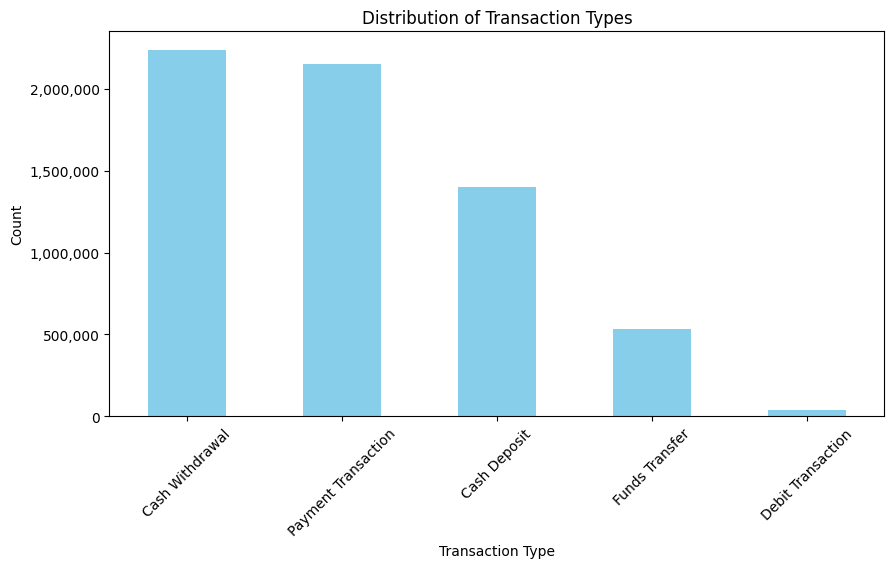

In [6]:
# Visualizing the distribution of transaction types
label_map = {
    "CASH_OUT": "Cash Withdrawal",
    "PAYMENT": "Payment Transaction",
    "CASH_IN": "Cash Deposit",
    "DEBIT": "Debit Transaction",
    "TRANSFER": "Funds Transfer"
}

plt.figure(figsize=(10, 5))
df["type"].map(label_map).value_counts().plot(kind="bar", color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Distribution of Transaction Types");

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

The second visualization highlights that fraud occurs disproportionately in Frunds Transfers and Cash Withdrawls, In contrast, Payments, Debits, and Deposits show almost no fradulent activity. This confirms the intuition that fraudsters prefer transaction types that allow fast movement or withdrawl of money. 

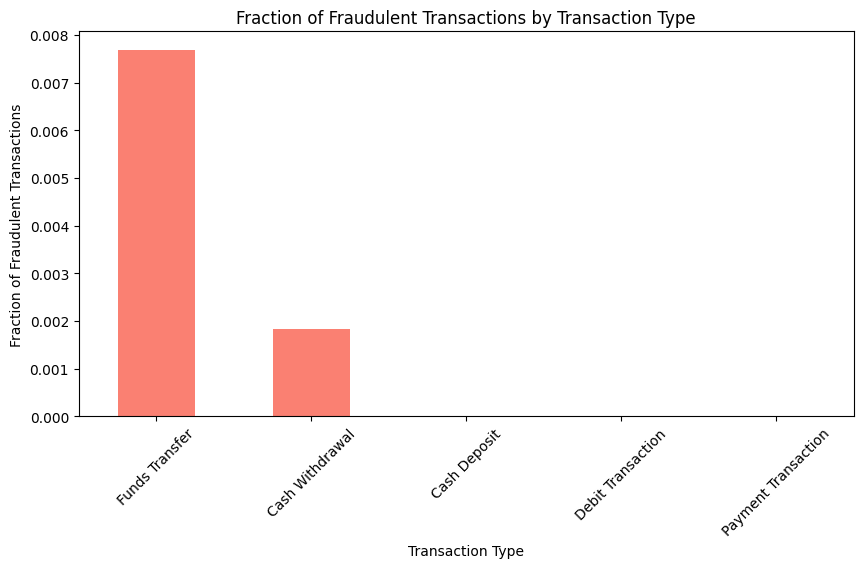

In [7]:
fraud_by_type = (
    df.groupby("type")["isFraud"]
      .mean()
      .rename(index=label_map) 
      .sort_values(ascending=False)
)
plt.figure(figsize=(10, 5))
fraud_by_type.plot(kind="bar", color='salmon')
plt.xticks(rotation=45)
plt.xlabel("Transaction Type")
plt.ylabel("Fraction of Fraudulent Transactions")
plt.title("Fraction of Fraudulent Transactions by Transaction Type");

plt.show()

We then analyze the distribution of transaction amounts. The descriptive statistics are:

In [8]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

Key takaways:

- The median transaction amount is $74,871. while the maximum exceeds 92 million, indicating a highly skewed distribution.
- The standard deviation ($603,858) is much larger than the mean, confirming extreme variability in amounts.
- Most transactions are relatively small, but a few large transactions heavily influence the distribution. 

This motivates the use of log-transformation for transaction amounts in later analysis, to better visualize and understand fraud patterns across different scales. 


The log-transformed distribution of transaction amounts shows that while raw amounts are heavily skewed, applying a log transformation reveals a clearer structure. The majority of transaction cluster around mid-range amounts, with distinct peaks. This suggests that certain transaction ranges are more common, and fraud may exploit specific amount bands. 

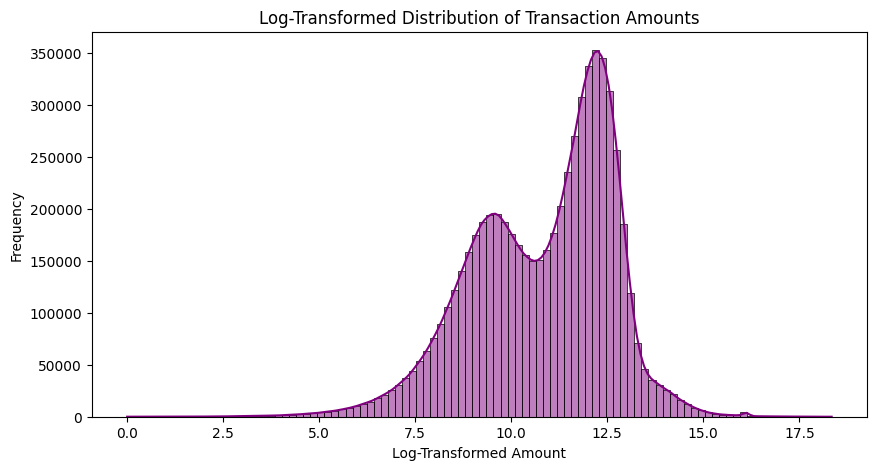

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color='purple')
plt.xlabel("Log-Transformed Amount")
plt.ylabel("Frequency")
plt.title("Log-Transformed Distribution of Transaction Amounts");

plt.show()

The boxplot comparing fradulent and non-fradulent transaction (capped at 50,000 for clarity) highlights an important insight: fradulent transaction typically involve larger amounts. While legitimate transactions tend to concentrate at smaller amounts, fraudsters prefer higher-value transfers and withdrawls. This reinforces transaction amount as a strong predictor in fraud detection models. 

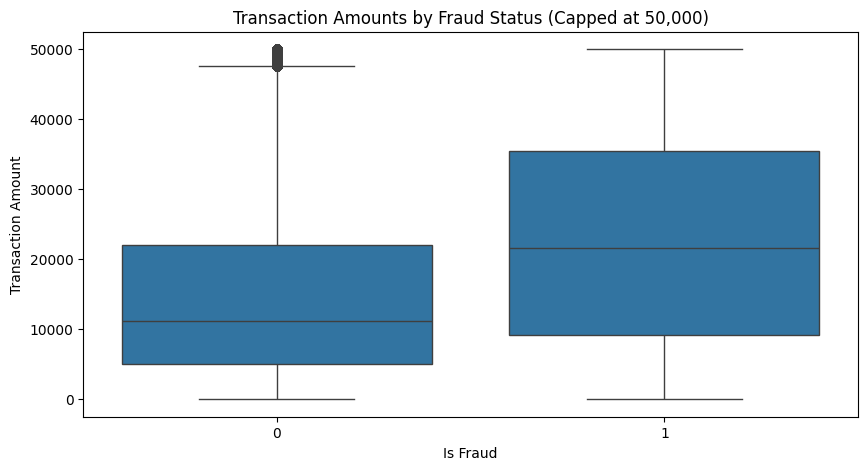

In [10]:
plt.figure(figsize=(10, 5))

sns.boxplot(data = df[df["amount"] < 50000], 
            x = "isFraud", 
            y = "amount")
plt.xlabel("Is Fraud")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amounts by Fraud Status (Capped at 50,000)");
plt.show()

New features was engineered to better capture balance behaviors:

In [11]:
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

print(int((df["balanceDiffOrig"] < 0).sum()), 'records has negative balance difference in origin account')

1399253 records has negative balance difference in origin account


Surprisingly, over 1.39 million records has a negative `balanceDiffOrig`, meaning the sender's balance after a transaction was greater than before. Such inconsistencies are strong indicators of data anomalies or potentially fradulenet behavior. 

The temporal analysis of fraud occurrences across steps (time intervals) reveals that fraud attempts are not evenly distributed. There are spikes at certain intervals, indicating concentrated bursts of fraud activity. This aligns with real-world fraud where criminals often execute campaigns of attacks during short windows of opportunity. 

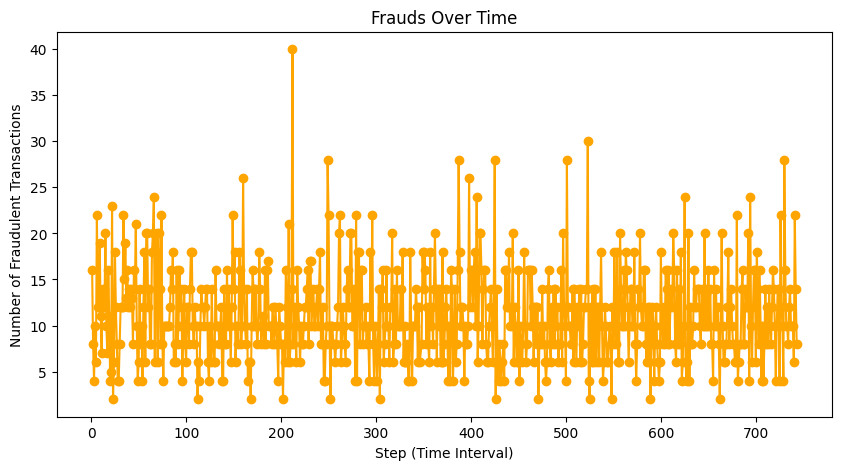

In [12]:
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(frauds_per_step.index, frauds_per_step.values, label = "Frauds per Step", marker='o', color='orange')
plt.xlabel("Step (Time Interval)")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Frauds Over Time");
plt.show()

After this analysis, we dropped the `step` column as it functions more as a time index rather than a predictive feature for this model. At this point, our dataset consisted of 12 features (7 numerical, 2 categorical, 3 identifiers/labels). The newly engineered features (`balanceDiffOrig`, `balanceDiffDest`) provide additional signals that may improve the model performance. 

In [13]:
df.drop(columns = "step", inplace = True)  

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   type             object 
 1   amount           float64
 2   nameOrig         object 
 3   oldbalanceOrg    float64
 4   newbalanceOrig   float64
 5   nameDest         object 
 6   oldbalanceDest   float64
 7   newbalanceDest   float64
 8   isFraud          int64  
 9   isFlaggedFraud   int64  
 10  balanceDiffOrig  float64
 11  balanceDiffDest  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 582.5+ MB


### Fraudulent Transactions by Type 

To better understand account behavior, we examined the most frequent senders and recievers in the dataset. 

The top senders list shows that the most active originating accounts only appear three times each, which is surprisingly low given the dataset size. This indicates that senders are highly distributed, most customers perform very few transactions, and there are no extreme "power users" dominating the sending side. This dispersion is typical in financial data, where each customer generally corresponds to a single account. 

In [15]:
top_senders = df["nameOrig"].value_counts().head(10)
top_senders

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In contrast, the top recievers show very different behavior. Some destination accounts recieve hundreds of transactions (e.g., account `C1286084959` with 113, `C985934102` with 109, etc). This concentration suggests that certain accounts act as hubs or collection points, which may be consistent with merchant accounts or, alternatively, fradulent "mule accounts" used to gather funds. Such accounts warrant deeper investigation since high inbound volume is a known risk factor for fraud. 

In [16]:
top_receivers = df["nameDest"].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

When we focus specifically on fradulent users, the pattern is even mroe interesting. The top 10 fradulent senders only show up once each in the dataset. This suggests that fraudsters may create and use accounts for a single fradulent transaction before abandoning them, a behavior consistent with real-world fraud tactics designed to avoid detection. It highlights the importance of incorporating account-level frequency features in modeling, since "one-off" accounts might be disproportionately fraudulent. 

In [17]:
fraud_users = df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

Next, we analyzed fraud distribution across transaction types. As expected the Cash Withdrawl (2.23 million transactions) and Fund Transfers (0.53 millon transaction) dominate fradulent activity. This confirms earlier findings that fraud is rarely attempted in Payments or Deposits, and instead focuses on transaction types that allow criminals to withdrawl or move money quickly. These two transaction types (Cash Withdrawl and Funds Transfer) should therefore be heavily weighted in model training and feature engineering. 

In [18]:
fraud_types = df[df["type"].isin(['TRANSFER', 'CASH_OUT'])].copy()
fraud_types["type"] = fraud_types["type"].map(label_map)
fraud_types["type"].value_counts()

type
Cash Withdrawal    2237500
Funds Transfer      532909
Name: count, dtype: int64

The analysis of fraudulent transactions across Transfers and Cash Withdrawal confirms earlier finding: these two transaction types account for nearly all fradulent cases. Other transaction categories such as Payments, Debits, and Deposits show virtually no fraud, emphasizing the narrow operational focus of fraudsters. 

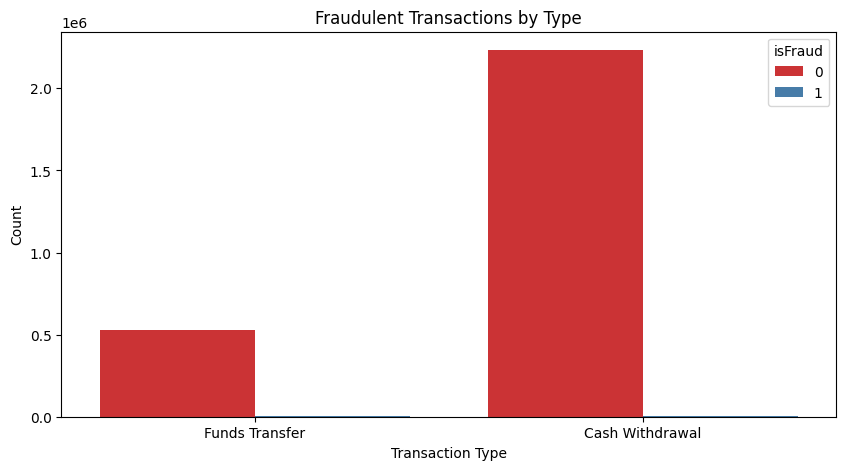

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(data=fraud_types, x="type", hue="isFraud", palette="Set1")
plt.title("Fraudulent Transactions by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

### Feature Correlations

The correlation matrix of key numerical features reveal:

- Strong correlations between `oldbalanceOrg` and `newbalanceOrig` (0.999) and between `oldbalanceDest` and `newbalanceDest` (0.977). These are expected, since balances before and after transaction are mechanically linked.
- Moderate correlations between transaction `amount` and destination balances (`oldbalanceDest` and `newbalanceDest`), suggesting that higher transaction amounts often correspond to higher receiving balances. 
- Very weak correaltions between `isFraud` and any of the numeric features (highest is `amount` at only 0.0767). 

This indicates that fraud cannot be explained by simple linear relationships, and that categorical and engineered features play a more important role in detection.

In [20]:
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


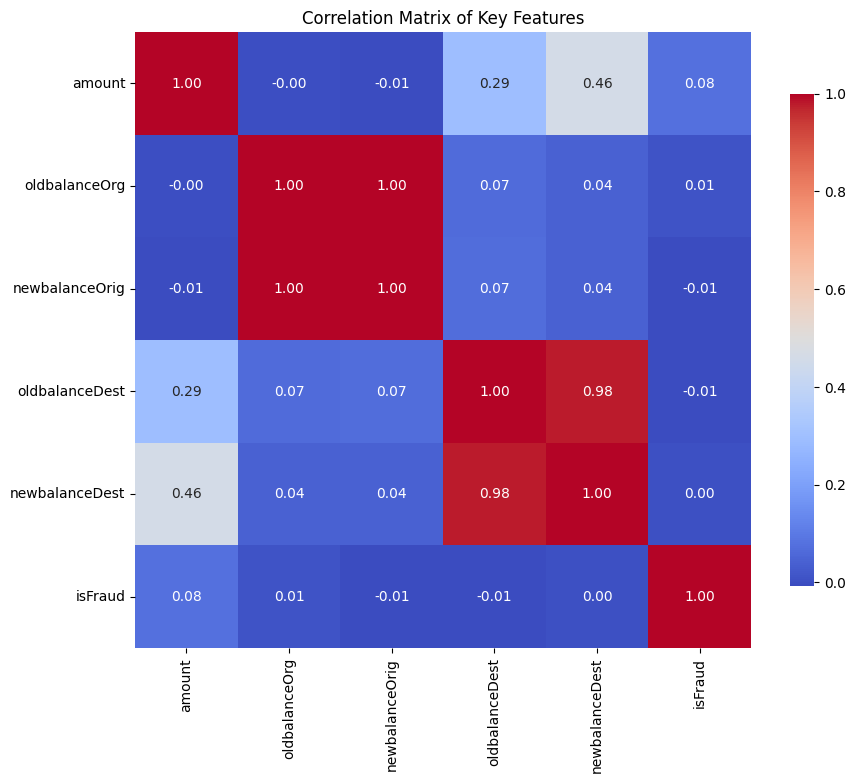

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Key Features")
plt.show()

### Zero-Balance After Transfer Analysis 

A notable anomaly arises when we check for transactions where the sender had a positive balance before the transaction but a zero balance immediately afterward, specifically for Transfers and Cash Withdrawal.

In [22]:
zero_after_transfer = df[(df["oldbalanceOrg"] > 0) & 
                         (df["newbalanceOrig"] == 0) & 
                         (df["type"].isin(["TRANSFER", "CASH_OUT"]))]
print(f'{len(zero_after_transfer)} fraudulent transactions where the sender had a non-zero balance prior to the transfer.')  # len(zero_after_transfer))

1188074 fraudulent transactions where the sender had a non-zero balance prior to the transfer.


This conditions identifies 1,188,074 transaction. Many of these cases are fraudulent, but not all. The table below shows examples:

- Fraudulent transfers (`isFraud = 1`) where the sender's balance is fully drained (rows 2, 3).
- Non-fraud cases with similar zero-after patterns, but abnormal shifts in the destination balances (rows 15, 19, 24). 

This finding highlights how fraudsters often empty accounts in a single transaction, leaving a clear behavioral signal. However, the presence of non-fradulent cases in the same conditional also shows why simple rules are not enough and machine learning is required. 

In [23]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


Finally a class distribution check confirms that the severe imbalance:

- 6,354,407 non-fraud cases
- 8,213 fraud cases

This imbalances (~0.13% fraud rate) emphasizes the challenge of building effective fraud detection models, the models must be desiged to handle highly skewed data. 

In [24]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

### Model Setup

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

We move from EDA to a supervised model using logistic regression wrapped in a scikit-learn Pipeline. The goal is to predict `isFraud` while preventing data leakage and handing strong class imbalance



In [27]:
df_model = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   type             object 
 1   amount           float64
 2   oldbalanceOrg    float64
 3   newbalanceOrig   float64
 4   oldbalanceDest   float64
 5   newbalanceDest   float64
 6   isFraud          int64  
 7   balanceDiffOrig  float64
 8   balanceDiffDest  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 436.9+ MB


Labeling the categorical and numeric for feature roles. The categorical variable `type` will be encoded with OneHotEncoder to create k-1 dummies and avoid collinearity ("dummy" trap). The numeric variable (`amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`) is standardized with StandardScaler so the model's coefficients are on a comparable scale, which improves convergence and interpretability. Afterward, we set `isFraud` is the target (`y`). All remaining columns form X. We will only keep the features listed below during preprocessing dropping the rest safely inside the pipeline. 

In [28]:
categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

y = df_model["isFraud"]
X = df_model.drop("isFraud", axis=1)

For the train/test split, we use a 70/30 split to keep a sizeable holdout set. Stratify preserves the rare fraud class proprotion in both splits, which is critical for imbalanced problems. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### Preprocessing and Model Pipeline

The ColumnTransformer applies the right transformation to each feature type, then discards everything else. The class weight which would be balanced tells logistic regression to up-weight fraud examples so the model does not default to predicting the majority class. Using a max iteration of 1000 gives the solver enough iterations to converge after scaling and one-hot encoding. 

In [30]:
preprocessor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder = "drop"
)

Fitting happens end-to-end the same preprocessing learned on the training data is applied to the test data automatically. This avoids any data leakage. The `y_pred` contains class predictions for threshold tuning and ranking you can also use. 

In [31]:
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight='balanced', max_iter=1000))
])

In [32]:
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
y_pred = pipeline.predict(X_test)

### Model Evaluation

After fitting the logistic regression pipeline, we evaluated the model on the test set. 

Classification Report:

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.95      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.94      0.97   1908786



Class 0 (Non-Fraud)

- Precision = 1.00 -> Nearly every predicted non-fraud case is correct
- Recall = 0.95 -> About 5% of legitmate transactions were incorrectly flagged as fraud. 
- Support = ~1.9 million -> The model is dominated by non-fraud predictions, which is expected given the extreme imbalance. 

Class 1 (Fraud)

- Precision = 0.02 -> Only 2% of transactions flagged as fraud are actually fraudlent. This means there are many false positives.
- Recall = 0.95 -> Almost all fraudulent transactions are detected. This is excellent in terms of coverage. 
- F1-score = 0.04 -> Low due to poor precision, showing the difficulty of balancing fraud detection

Confusion Matrix:

In [35]:
print(confusion_matrix(y_test, y_pred)) 

[[1800316  106006]
 [    127    2337]]


Confusion Matrix Breakdown

- True Negatives (TN): 1,805,867 -> Majority of legitimate transactions correctly classified. 
- False Positives (FP): 100,455 -> Legitimate transactions incorrectly flagged as fraud.
- False Negatives (FN): 133 -> Very frew fraud cases when undetected.
- True Positives (TP): 2,331 -> Most fraud cases correctly detected.

In [36]:
print(f"Accuracy: {pipeline.score(X_test, y_test)}")

Accuracy: 0.9443976433188425


Overall accuracy looks strong at ~95%, but this is misleading due to class imbalance. The macro average highlights imbalance: recall is strong, but precision drags down F1. The weighted averages are inflated by the overwhelming number of non-fraud cases.

The key takaways is the high recall (0.95) on fraud is a success. The model catches almost all fraudulent activity. However, the precision (0.02) is extremely low, meaning the system raises many false alarms. In fraud detection, this trade-off can be acceptable, better to investigate false positives than miss frauds, but it also shows the need for improvement.

### Fraud Detection App

After building and validating the logistic regression pipeline, the next step was to package it for reuse. Instead of retraining the model each time, we saved the entire pipeline including preprocessing and the trained classifier into a single file using joblib:

In [37]:
import joblib

joblib.dump(pipeline, "fraud_detection_model.pkl")

['fraud_detection_model.pkl']

To run the website, type in the terminal this command such this file is located in the same directory

```bash 
streamlit run fraud_detection_app.py
```

This file (`fraud_detection_model.pkl`) can be loaded back into memory at any time to make predictions on new data without having to repeat the training process. 


By saving the full pipeline, we ensure:
- Consistency: The extract transformations and model parameters used during training are preserved. 
- Efficency: Avoids retraining on millions of records every time the model is needed.
- Deployability: The saved model can be integrated into an application (e.g., a web service or real-time fraud monitoring system) to flag suspicious transaction automatically. 

This essentially turns the pipeline into a fraud detection app which is capable of ingesting transaction data, applying the necessary preprocessing, and returning fraud predictions in a seamless and reproducible manner. 